## Gradient boosting attempt

__This attempt is done as part of our ICS 435 Final Project__

---
**About Gradient Boosting**
- Ensemble method used for classification and regression tasks; Popular for tabular supervised learning tasks
- Boosting algorithm which combines multiple weak learners to create a strong predictive model 
- Sequentially trains models where each new model tries to correct the errors made by its predecessor

### Looking at dataset
- Dataset source: https://huggingface.co/datasets/akridge/NOAA-ESD-CORAL-Bleaching-Dataset 

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import os
import glob
from PIL import Image
import time
import random
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
# set random seed for reproducibility
np.random.seed(42)

In [4]:
# load downloaded dataset from local directory
dataset_path = "./NOAA-ESD-CORAL-Bleaching-Dataset"

In [ ]:
# gets image paths and labels
def get_dataset_info(dataset_path):
    # dictionary to store image paths by split and class
    dataset_info = {}
    
    # go through each split (train, test, val)
    for split in ['train', 'test', 'val']:
        split_path = os.path.join(dataset_path, split)
        if not os.path.exists(split_path):
            print(f"Warning: {split_path} does not exist")
            continue
            
        # Create entry for this split
        dataset_info[split] = {'CORAL': [], 'CORAL_BL': []}
        
        # Get healthy coral images
        healthy_path = os.path.join(split_path, 'CORAL')
        if os.path.exists(healthy_path):
            for img_file in os.listdir(healthy_path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    dataset_info[split]['CORAL'].append(os.path.join(healthy_path, img_file))
        
        # Get bleached coral images
        bleached_path = os.path.join(split_path, 'CORAL_BL')
        if os.path.exists(bleached_path):
            for img_file in os.listdir(bleached_path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    dataset_info[split]['CORAL_BL'].append(os.path.join(bleached_path, img_file))
    
    return dataset_info

In [7]:
# get dataset information
dataset_info = get_dataset_info(dataset_path)

In [8]:
# print dataset statistics
print("Dataset Statistics:")
for split in dataset_info:
    healthy_count = len(dataset_info[split]['CORAL'])
    bleached_count = len(dataset_info[split]['CORAL_BL'])
    total = healthy_count + bleached_count
    
    print(f"  {split.capitalize()} set:")
    print(f"    Healthy corals: {healthy_count}")
    print(f"    Bleached corals: {bleached_count}")
    print(f"    Total: {total}")

Dataset Statistics:
  Train set:
    Healthy corals: 4541
    Bleached corals: 2751
    Total: 7292
  Test set:
    Healthy corals: 974
    Bleached corals: 591
    Total: 1565
  Val set:
    Healthy corals: 973
    Bleached corals: 589
    Total: 1562


---

### Looking at sample images

In [11]:
# function to display sample images within each class
def display_sample_images(dataset_info, split='train', samples_per_class=3):
    """Display sample images from each class"""
    if split not in dataset_info:
        print(f"Split '{split}' not found in dataset")
        return
        
    plt.figure(figsize=(12, 5))
    
    # display healthy coral samples
    healthy_samples = random.sample(dataset_info[split]['CORAL'], 
                                  min(samples_per_class, len(dataset_info[split]['CORAL'])))
    
    for i, img_path in enumerate(healthy_samples):
        img = Image.open(img_path)
        plt.subplot(2, samples_per_class, i+1)
        plt.imshow(img)
        plt.title(f"Healthy Coral")
        plt.axis('off')
    
    # display bleached coral samples
    bleached_samples = random.sample(dataset_info[split]['CORAL_BL'], 
                                   min(samples_per_class, len(dataset_info[split]['CORAL_BL'])))
    
    for i, img_path in enumerate(bleached_samples):
        img = Image.open(img_path)
        plt.subplot(2, samples_per_class, i+samples_per_class+1)
        plt.imshow(img)
        plt.title(f"Bleached Coral")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_images.png')
    plt.show()

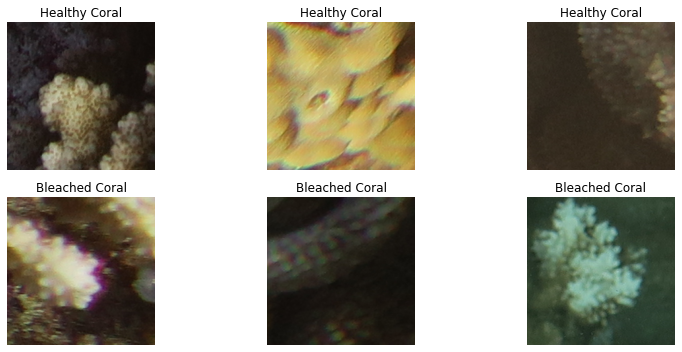

In [12]:
# calling the function to display sample images
display_sample_images(dataset_info, 'train')

In [ ]:
# feature extraction function
def extract_features_from_image(image_path, resize_to=(128, 128)):
    """
    Extract numeric features from an image
    """
    try:
        # Open image
        img = Image.open(image_path)
        
        # Convert to RGB if needed (in case of RGBA or other formats)
        if img.mode != 'RGB':
            img = img.convert('RGB')
            
        # Convert to grayscale for feature extraction
        img_gray = img.convert('L')
        
        # Resize
        img_gray = img_gray.resize(resize_to)
        
        # Convert to numpy array
        img_array = np.array(img_gray)
        
        # FEATURE SET 1: Basic statistical features
        mean_pixel = np.mean(img_array)
        std_pixel = np.std(img_array)
        min_pixel = np.min(img_array)
        max_pixel = np.max(img_array)
        
        # FEATURE SET 2: Histogram features (20 bins)
        hist, _ = np.histogram(img_array, bins=20, range=(0, 256))
        hist = hist / hist.sum()  # Normalize
        
        # FEATURE SET 3: Texture features using gradients
        dx = np.gradient(img_array, axis=1)
        dy = np.gradient(img_array, axis=0)
        
        gradient_magnitude = np.sqrt(dx**2 + dy**2)
        mean_gradient = np.mean(gradient_magnitude)
        std_gradient = np.std(gradient_magnitude)
        
        # FEATURE SET 4: Regional features (divide image into 4 quadrants)
        h, w = img_array.shape
        h_half, w_half = h // 2, w // 2
        
        # Top-left, top-right, bottom-left, bottom-right quadrants
        q1 = img_array[:h_half, :w_half]
        q2 = img_array[:h_half, w_half:]
        q3 = img_array[h_half:, :w_half]
        q4 = img_array[h_half:, w_half:]
        
        # Mean and std for each quadrant
        q1_mean, q1_std = np.mean(q1), np.std(q1)
        q2_mean, q2_std = np.mean(q2), np.std(q2)
        q3_mean, q3_std = np.mean(q3), np.std(q3)
        q4_mean, q4_std = np.mean(q4), np.std(q4)
        
        # FEATURE SET 5: Edge density in each quadrant
        q1_edge = np.mean(np.sqrt(np.gradient(q1, axis=0)**2 + np.gradient(q1, axis=1)**2))
        q2_edge = np.mean(np.sqrt(np.gradient(q2, axis=0)**2 + np.gradient(q2, axis=1)**2))
        q3_edge = np.mean(np.sqrt(np.gradient(q3, axis=0)**2 + np.gradient(q3, axis=1)**2))
        q4_edge = np.mean(np.sqrt(np.gradient(q4, axis=0)**2 + np.gradient(q4, axis=1)**2))
        
        # FEATURE SET 6: Color features (from RGB channels)
        # Convert back to RGB and get channel means
        img_rgb = img.resize(resize_to)
        img_rgb_array = np.array(img_rgb)
        
        r_mean = np.mean(img_rgb_array[:,:,0])
        g_mean = np.mean(img_rgb_array[:,:,1])
        b_mean = np.mean(img_rgb_array[:,:,2])
        
        r_std = np.std(img_rgb_array[:,:,0])
        g_std = np.std(img_rgb_array[:,:,1])
        b_std = np.std(img_rgb_array[:,:,2])
        
        # Calculate color ratios (useful for coral bleaching detection)
        rg_ratio = r_mean / (g_mean + 1e-10)
        rb_ratio = r_mean / (b_mean + 1e-10)
        gb_ratio = g_mean / (b_mean + 1e-10)
        
        # Combine all features
        features = [
            # Basic stats
            mean_pixel, std_pixel, min_pixel, max_pixel, 
            # Gradient stats
            mean_gradient, std_gradient,
            # Quadrant means
            q1_mean, q2_mean, q3_mean, q4_mean,
            # Quadrant std devs
            q1_std, q2_std, q3_std, q4_std,
            # Quadrant edge density
            q1_edge, q2_edge, q3_edge, q4_edge,
            # Color features
            r_mean, g_mean, b_mean,
            r_std, g_std, b_std,
            # Color ratios
            rg_ratio, rb_ratio, gb_ratio
        ]
        
        # Add histogram features
        features.extend(hist)
        
        # Add downsampled pixels (8x8 grid from 128x128)
        downsampled = img_array[::16, ::16].flatten()
        features.extend(downsampled)
        
        return features
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [14]:
def create_dataset(dataset_info, split='train', max_samples_per_class=None):
    """Create a dataset with features extracted from images"""
    features_list = []
    labels = []
    image_paths = []
    
    # Process healthy corals
    print(f"Processing healthy corals from {split} set...")
    healthy_images = dataset_info[split]['CORAL']
    if max_samples_per_class is not None:
        healthy_images = healthy_images[:max_samples_per_class]
        
    for i, img_path in enumerate(healthy_images):
        if i % 50 == 0:
            print(f"  Processed {i}/{len(healthy_images)} healthy coral images")
            
        features = extract_features_from_image(img_path)
        if features is not None:
            features_list.append(features)
            labels.append('CORAL')
            image_paths.append(img_path)
    
    # Process bleached corals
    print(f"Processing bleached corals from {split} set...")
    bleached_images = dataset_info[split]['CORAL_BL']
    if max_samples_per_class is not None:
        bleached_images = bleached_images[:max_samples_per_class]
        
    for i, img_path in enumerate(bleached_images):
        if i % 50 == 0:
            print(f"  Processed {i}/{len(bleached_images)} bleached coral images")
            
        features = extract_features_from_image(img_path)
        if features is not None:
            features_list.append(features)
            labels.append('CORAL_BL')
            image_paths.append(img_path)
    
    # Create feature names
    feature_columns = [
        'mean_pixel', 'std_pixel', 'min_pixel', 'max_pixel',
        'mean_gradient', 'std_gradient',
        'q1_mean', 'q2_mean', 'q3_mean', 'q4_mean',
        'q1_std', 'q2_std', 'q3_std', 'q4_std',
        'q1_edge', 'q2_edge', 'q3_edge', 'q4_edge',
        'r_mean', 'g_mean', 'b_mean',
        'r_std', 'g_std', 'b_std',
        'rg_ratio', 'rb_ratio', 'gb_ratio'
    ]
    
    # Add histogram bin names
    feature_columns.extend([f'hist_bin_{i}' for i in range(20)])
    
    # Add downsampled pixel names
    pixel_count = len(features_list[0]) - len(feature_columns)
    feature_columns.extend([f'pixel_{i}' for i in range(pixel_count)])
    
    # Create DataFrame
    df = pd.DataFrame(features_list, columns=feature_columns)
    df['label'] = labels
    df['image_path'] = image_paths
    
    return df


In [15]:
# Create dataset from training images
# Limit samples per class for faster processing if needed
# Set max_samples_per_class=None to use all images
print("Creating feature dataset from training images...")
start_time = time.time()
train_df = create_dataset(dataset_info, 'train', max_samples_per_class=500)
print(f"Dataset creation completed in {time.time() - start_time:.2f} seconds")

# Save the dataset
train_df.to_csv('coral_train_features.csv', index=False)
print(f"Training dataset saved with {train_df.shape[0]} samples and {train_df.shape[1]} features")

Creating feature dataset from training images...
Processing healthy corals from train set...
  Processed 0/500 healthy coral images
  Processed 50/500 healthy coral images
  Processed 100/500 healthy coral images
  Processed 150/500 healthy coral images
  Processed 200/500 healthy coral images
  Processed 250/500 healthy coral images
  Processed 300/500 healthy coral images
  Processed 350/500 healthy coral images
  Processed 400/500 healthy coral images
  Processed 450/500 healthy coral images
Processing bleached corals from train set...
  Processed 0/500 bleached coral images
  Processed 50/500 bleached coral images
  Processed 100/500 bleached coral images
  Processed 150/500 bleached coral images
  Processed 200/500 bleached coral images
  Processed 250/500 bleached coral images
  Processed 300/500 bleached coral images
  Processed 350/500 bleached coral images
  Processed 400/500 bleached coral images
  Processed 450/500 bleached coral images
Dataset creation completed in 3.48 sec

---

### exploratory data analysis


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 113 entries, mean_pixel to image_path
dtypes: float64(45), int8(66), object(2)
memory usage: 431.8+ KB
None

Sample of the dataset (first 5 rows):
   mean_pixel  std_pixel  min_pixel  max_pixel  mean_gradient  std_gradient  \
0  138.866272  20.366650         70        -33      13.414811     10.180728   
1   63.031677  37.180414         19        -46       5.199310      5.624522   
2   70.439331  24.232612         26       -114       2.777257      2.344962   
3   95.552063  32.225324         31        -93       2.751159      2.340222   
4   70.111023  33.213169          8        -66       7.930518      7.679246   

      q1_mean     q2_mean     q3_mean     q4_mean  ...  pixel_56  pixel_57  \
0  140.743408  140.367188  141.291748  133.062744  ...       -51       112   
1   56.536621   78.207520   63.960449   53.422119  ...        33        35   
2   65.670410   61.264160   99.683594   

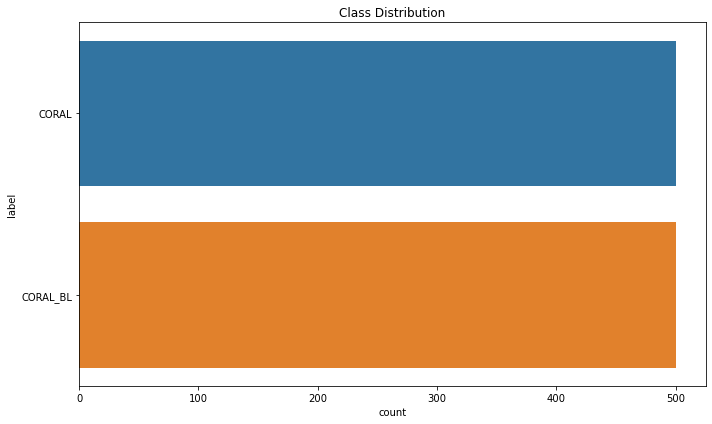

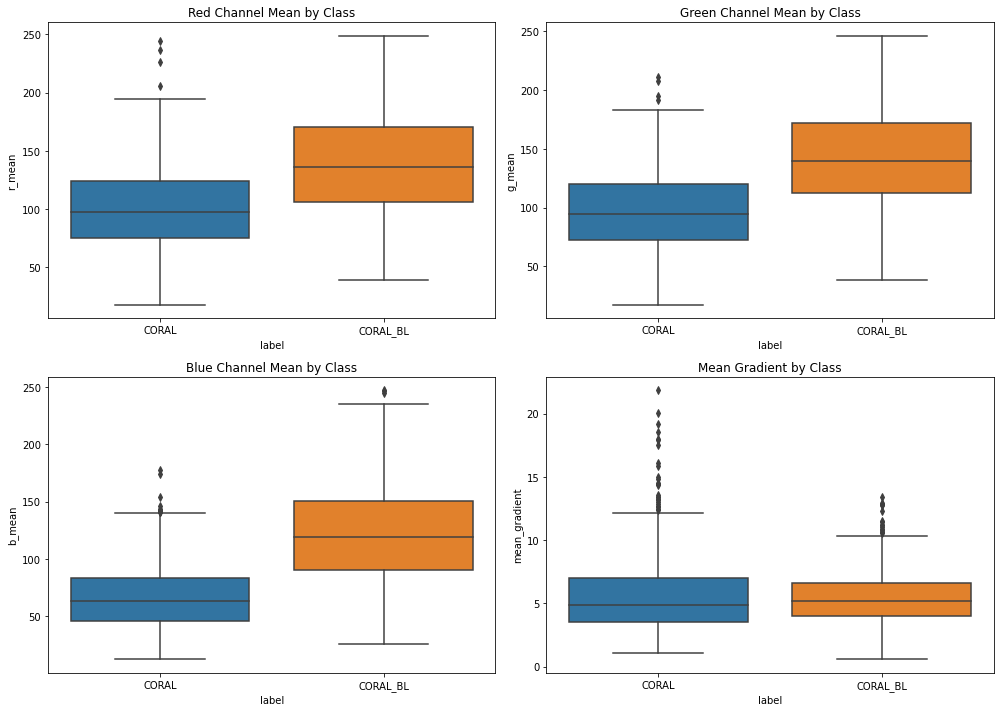

In [16]:
# Basic dataset info
print("\nDataset Information:")
print(train_df.info())
print("\nSample of the dataset (first 5 rows):")
print(train_df.head())

# Check class distribution
print("\nClass distribution:")
class_distribution = train_df['label'].value_counts()
print(class_distribution)

plt.figure(figsize=(10, 6))
sns.countplot(y='label', data=train_df)
plt.title('Class Distribution')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

# Visualize some important features
plt.figure(figsize=(14, 10))

# Color means by class
plt.subplot(2, 2, 1)
sns.boxplot(x='label', y='r_mean', data=train_df)
plt.title('Red Channel Mean by Class')

plt.subplot(2, 2, 2)
sns.boxplot(x='label', y='g_mean', data=train_df)
plt.title('Green Channel Mean by Class')

plt.subplot(2, 2, 3)
sns.boxplot(x='label', y='b_mean', data=train_df)
plt.title('Blue Channel Mean by Class')

plt.subplot(2, 2, 4)
sns.boxplot(x='label', y='mean_gradient', data=train_df)
plt.title('Mean Gradient by Class')

plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.show()

### Data preparation

In [17]:
# Split features and target
X = train_df.drop(['label', 'image_path'], axis=1)
y = train_df['label']

# Create label encoder to convert class names to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"Label mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

Label mapping: {'CORAL': 0, 'CORAL_BL': 1}
Training set size: 800
Validation set size: 200


---

### Training the Gradient Boosting Model

In [ ]:
print("\nTraining Gradient Boosting model...")
start_time = time.time()

# Initialize model with parameters
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)

# Train the model
gb_model.fit(X_train_scaled, y_train)
print(f"Training completed in {time.time() - start_time:.2f} seconds")


Training Gradient Boosting model...
Training completed in 3.36 seconds


### Evaluate model on generated validation set


Validation Accuracy: 0.8200

Classification Report (Validation Set):
              precision    recall  f1-score   support

       CORAL       0.83      0.80      0.82       100
    CORAL_BL       0.81      0.84      0.82       100

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200



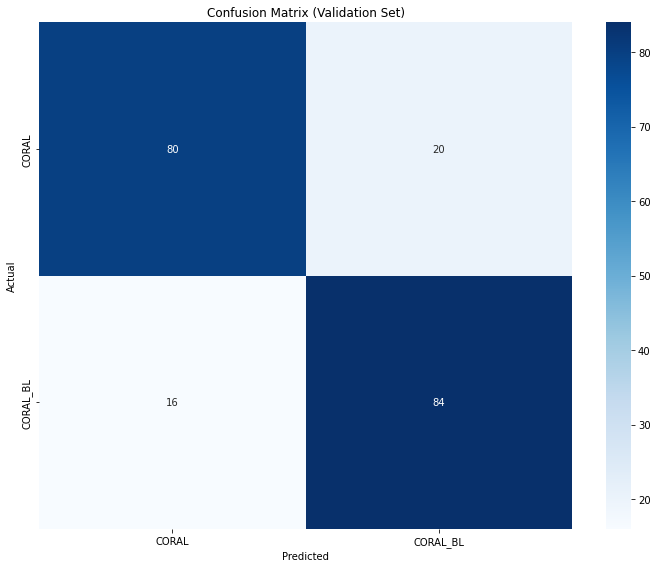

In [19]:
# Predict on validation set
y_val_pred = gb_model.predict(X_val_scaled)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")

# Classification report
print("\nClassification Report (Validation Set):")
target_names = label_encoder.classes_
print(classification_report(y_val, y_val_pred, target_names=target_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.savefig('confusion_matrix_validation.png')
plt.show()

---

### Create test set features


Creating feature dataset from test images...
Processing healthy corals from test set...
  Processed 0/974 healthy coral images
  Processed 50/974 healthy coral images
  Processed 100/974 healthy coral images
  Processed 150/974 healthy coral images
  Processed 200/974 healthy coral images
  Processed 250/974 healthy coral images
  Processed 300/974 healthy coral images
  Processed 350/974 healthy coral images
  Processed 400/974 healthy coral images
  Processed 450/974 healthy coral images
  Processed 500/974 healthy coral images
  Processed 550/974 healthy coral images
  Processed 600/974 healthy coral images
  Processed 650/974 healthy coral images
  Processed 700/974 healthy coral images
  Processed 750/974 healthy coral images
  Processed 800/974 healthy coral images
  Processed 850/974 healthy coral images
  Processed 900/974 healthy coral images
  Processed 950/974 healthy coral images
Processing bleached corals from test set...
  Processed 0/591 bleached coral images
  Processe

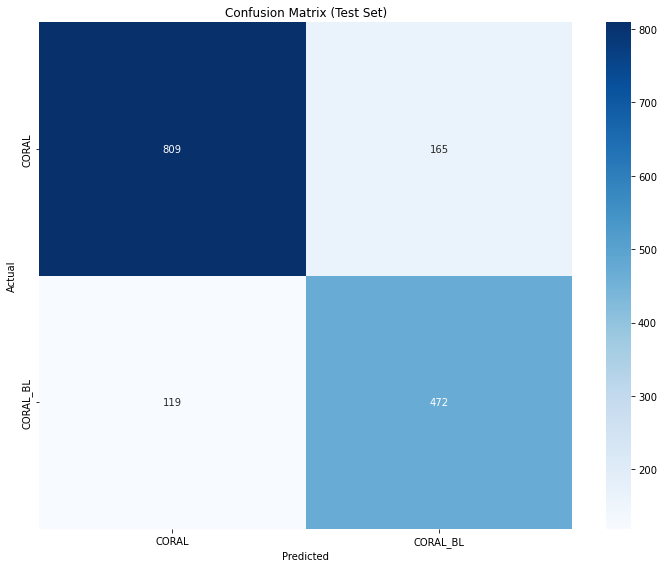

In [20]:
# Only if test split is available in the dataset
if 'test' in dataset_info:
    print("\nCreating feature dataset from test images...")
    start_time = time.time()
    test_df = create_dataset(dataset_info, 'test', max_samples_per_class=None)
    print(f"Test dataset creation completed in {time.time() - start_time:.2f} seconds")
    
    # Save the test dataset
    test_df.to_csv('coral_test_features.csv', index=False)
    print(f"Test dataset saved with {test_df.shape[0]} samples and {test_df.shape[1]} features")
    
    # Prepare test data
    X_test = test_df.drop(['label', 'image_path'], axis=1)
    y_test = test_df['label']
    y_test_encoded = label_encoder.transform(y_test)
    
    # Scale test features
    X_test_scaled = scaler.transform(X_test)
    
    # Predict on test set
    y_test_pred = gb_model.predict(X_test_scaled)
    
    # Calculate accuracy
    test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_encoded, y_test_pred, target_names=target_names))
    
    # Confusion Matrix for test set
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test_encoded, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Test Set)')
    plt.tight_layout()
    plt.savefig('confusion_matrix_test.png')
    plt.show()

In [21]:
# cross-validation
print("\nPerforming 5-fold cross-validation...")
cv_scores = cross_val_score(gb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")


Performing 5-fold cross-validation...
Cross-validation scores: [0.825   0.825   0.85    0.775   0.80625]
Mean CV accuracy: 0.8162
Standard deviation: 0.0249


In [22]:
# feature importance

print("\nPerforming 5-fold cross-validation...")
cv_scores = cross_val_score(gb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")


Performing 5-fold cross-validation...
Cross-validation scores: [0.825   0.825   0.85    0.775   0.80625]
Mean CV accuracy: 0.8162
Standard deviation: 0.0249


In [ ]:
# save model and preprocessers
print("\nSaving model and preprocessors...")
joblib.dump(gb_model, 'gradient_boosting_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Model and preprocessors saved to disk.")


Saving model and preprocessors...
Model and preprocessors saved to disk.
